In [0]:
import os
import random
import numpy as np
#import tensorflow as tf

import pandas as pd 
from sklearn.preprocessing import LabelEncoder
#from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, hstack
#from itertools import combinations
from sklearn.linear_model import LinearRegression
import re
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from multiprocessing import Pool
import gc
import time
import nltk
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score,RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

os.getcwd()


'/content'

In [0]:
import sys
!ls
df = pd.read_csv('drive/My Drive/mercari/train.tsv', sep='\t')

drive  sample_data


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# EDA

In [0]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [0]:
df['price'].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

In [0]:
null_values = df.isnull().sum().to_frame('count')
null_values = null_values[null_values['count'] > 0]


Text(0.5, 1.0, 'Price Distribution')

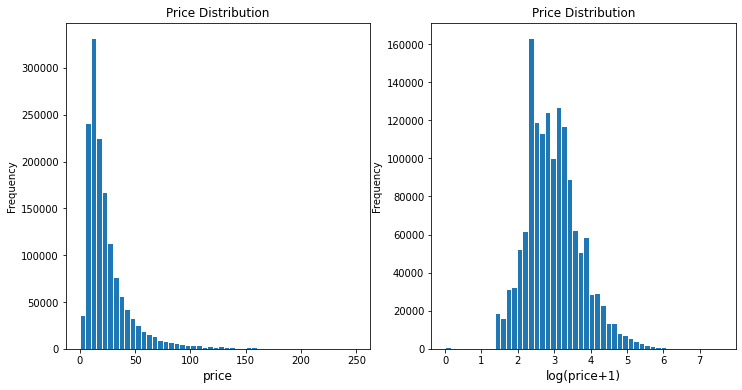

In [0]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
(df['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

plt.subplot(1, 2, 2)
np.log(df['price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)

In [0]:
df['shipping'].value_counts() / len(df)

0    0.552726
1    0.447274
Name: shipping, dtype: float64

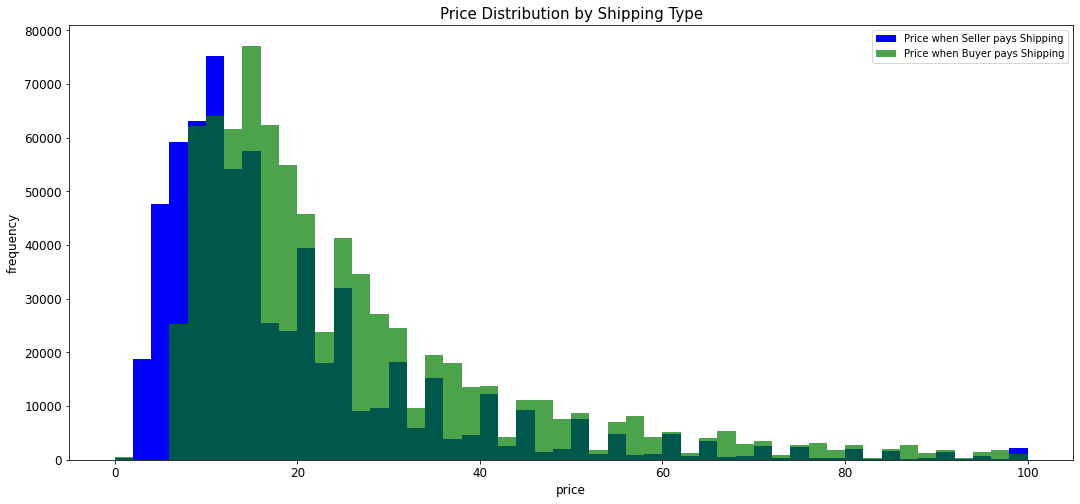

In [0]:
shipping_fee_by_buyer = df.loc[df['shipping'] == 0, 'price']
shipping_fee_by_seller = df.loc[df['shipping'] == 1, 'price']
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(shipping_fee_by_seller, color='blue', alpha=1.0, bins=50, range = [0, 100],
       label='Price when Seller pays Shipping')
ax.hist(shipping_fee_by_buyer, color='#007D00', alpha=0.7, bins=50, range = [0, 100],
       label='Price when Buyer pays Shipping')
plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

In [0]:
df['category_name'].value_counts()[:10]

Women/Athletic Apparel/Pants, Tights, Leggings                 60177
Women/Tops & Blouses/T-Shirts                                  46380
Beauty/Makeup/Face                                             34335
Beauty/Makeup/Lips                                             29910
Electronics/Video Games & Consoles/Games                       26557
Beauty/Makeup/Eyes                                             25215
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    24676
Women/Underwear/Bras                                           21274
Women/Tops & Blouses/Tank, Cami                                20284
Women/Tops & Blouses/Blouse                                    20284
Name: category_name, dtype: int64

In [0]:
brand_names = df.groupby('brand_name').size() 
df['brand_name'].value_counts()[:10]

PINK                 54088
Nike                 54043
Victoria's Secret    48036
LuLaRoe              31024
Apple                17322
FOREVER 21           15186
Nintendo             15007
Lululemon            14558
Michael Kors         13928
American Eagle       13254
Name: brand_name, dtype: int64

# Data Cleaning

In [0]:
def parallelize_dataframe(df1, func):
    df_split = np.array_split(df1, 4)
    pool = Pool(4)
    df1 = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df1
def clean_str_df(df1):
    return df1.apply( lambda s : clean_str(s))

In [0]:
 def fill_brand_name(x):
        try:
            k=[]
            for n in [4,3,2,1]:
                temp =  [' '.join(xi) for xi in ngrams(x.split(' '), n) if ' '.join(xi) in   brand_names  ] 
                if len(temp)>0:
                    k = k+temp
            if len(k) > 0:
                return k[0]
            else:
                return np.NaN
        except:
            return np.NaN

In [0]:
def clean_str(text):
    try:
        text = ' '.join( [w for w in text.split()[:max_text_length]] )        
        text = text.lower()
        text = re.sub(u"é", u"e", text)
        text = re.sub(u"ē", u"e", text)
        text = re.sub(u"è", u"e", text)
        text = re.sub(u"ê", u"e", text)
        text = re.sub(u"à", u"a", text)
        text = re.sub(u"â", u"a", text)
        text = re.sub(u"ô", u"o", text)
        text = re.sub(u"ō", u"o", text)
        text = re.sub(u"ü", u"u", text)
        text = re.sub(u"ï", u"i", text)
        text = re.sub(u"ç", u"c", text)
        text = re.sub(u"\u2019", u"'", text)
        text = re.sub(u"\xed", u"i", text)
        text = re.sub(u"w\/", u" with ", text)
        
        text = re.sub(u"[^a-z0-9]", " ", text)
        text = u" ".join(re.split('(\d+)',text) )
        text = re.sub( u"\s+", u" ", text ).strip()
        text = ''.join(text)
    except:
        text = text
    return text

In [0]:
df['brand_name'] = parallelize_dataframe(df['brand_name'], clean_str_df)  
df['name'] = parallelize_dataframe(df['name'], clean_str_df)  
df['item_description'] = parallelize_dataframe(df['item_description'], clean_str_df)                                                                            
    
df.loc[df['brand_name'].isnull(), 'brand_name'] = df.loc[df['brand_name'].isnull(),'name'].apply(fill_brand_name)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: generator 'ngrams' raised StopIteration
  """


In [0]:
df['brand_name'].isnull().sum()
df['brand_name'].value_counts().head(10)


PINK                 56687
Nike                 56491
Victoria's Secret    49519
LuLaRoe              38572
Apple                19155
Nintendo             15792
FOREVER 21           15193
Michael Kors         14971
Lululemon            14922
Rae Dunn             14664
Name: brand_name, dtype: int64

In [0]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
train.shape, test.shape

((1186378, 8), (296157, 8))

In [0]:
def handle_missing_inplace(dataset): 
    dataset['category_name'].fillna(value='missing', inplace=True) 
    dataset['brand_name'].fillna(value='missing', inplace=True) 
    dataset['item_description'].replace('No description yet,''missing', inplace=True) 
    dataset['item_description'].fillna(value='missing', inplace=True)
def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category = dataset['category_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]
def to_categorical(dataset):
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')
    dataset['shipping'] = dataset['shipping'].astype('category')

In [0]:
test_new = test.drop('price', axis=1)
y_test = np.log1p(test["price"])
train = train[train.price != 0].reset_index(drop=True)

In [0]:
nrow_train = train.shape[0]
y = np.log1p(train["price"])
merge: pd.DataFrame = pd.concat([train, test_new])

In [0]:
NUM_BRANDS = 4800
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000

# Wordclouds

(-0.5, 1439.5, 1079.5, -0.5)

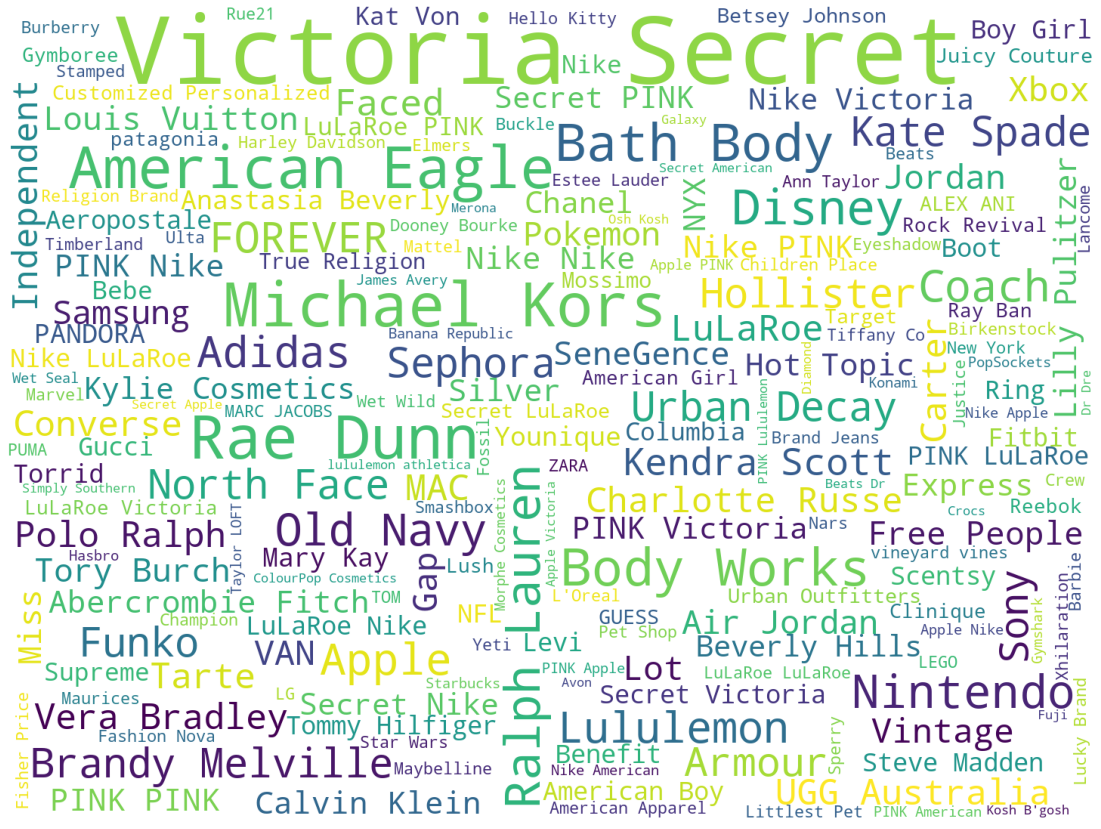

In [0]:
from wordcloud import WordCloud, STOPWORDS 
cloud = WordCloud(background_color="white",width=1440, height=1080).generate(" ".join(df['item_description'].astype(str)))
newdf=df['brand_name'].dropna()
cloud1 = WordCloud(background_color="white",width=1440, height=1080).generate(" ".join(newdf.astype(str)))

plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.imshow(cloud1)
plt.axis('off')

(-0.5, 1439.5, 1079.5, -0.5)

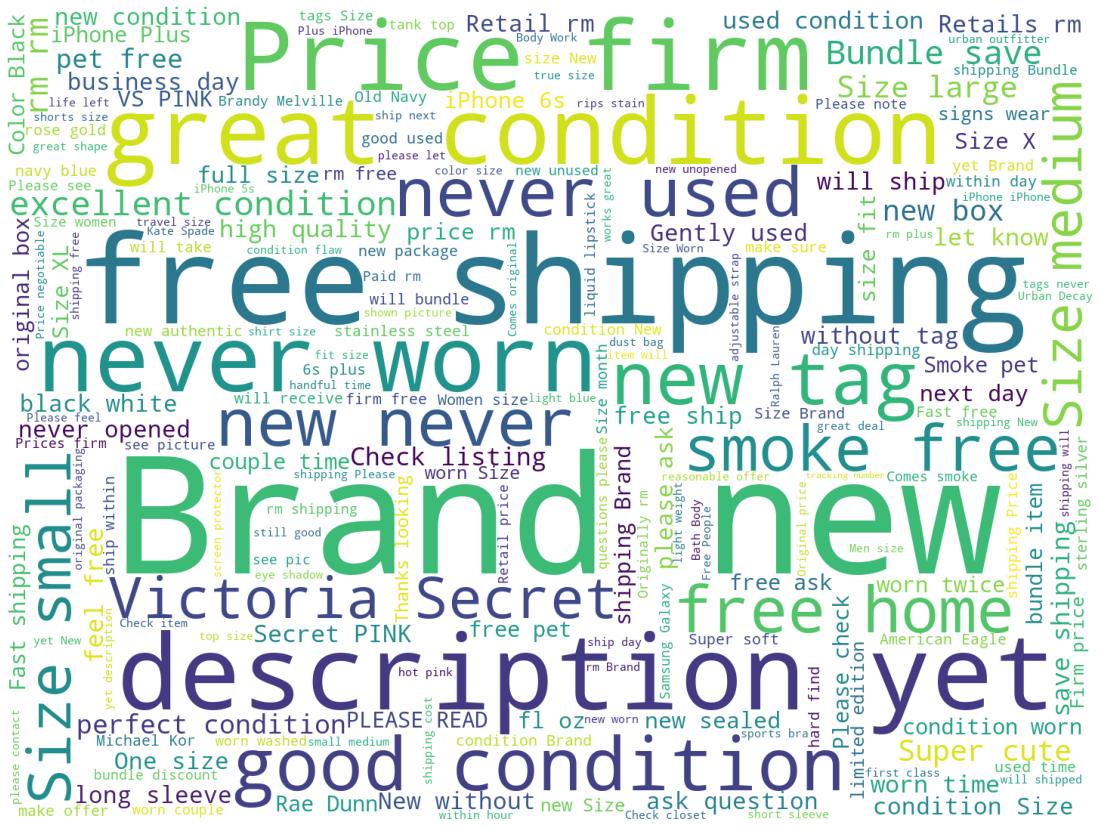

In [0]:
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

In [0]:
handle_missing_inplace(merge)
cutting(merge)
to_categorical(merge)

# Pre-processing: TF-IDF and Count vectorizer

In [0]:
cv = CountVectorizer(min_df=NAME_MIN_DF)
X_name = cv.fit_transform(merge['name'])
cv = CountVectorizer()
X_category = cv.fit_transform(merge['category_name'])
#cv = CountVectorizer(min_df=NAME_MIN_DF)
#X_name = cv.fit_transform(merge['name'])

In [0]:
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tv.fit_transform(merge['item_description'])

In [0]:
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(merge['brand_name'])


# Topic Modeling using LDA

In [0]:
cv_lda = CountVectorizer(min_df=NAME_MIN_DF,
                              max_features=MAX_FEATURES_ITEM_DESCRIPTION,
                              ngram_range=(1,2))

In [0]:
X_desc_lda = cv_lda.fit_transform(merge['item_description'])

In [0]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=5,
                                      learning_method='online',
                                      max_iter=20,
                                      doc_topic_prior=0.2,
                                      topic_word_prior=0.2,
                                      random_state=42)

In [0]:
X_topic=lda_model.fit_transform(X_desc_lda)

In [0]:
n_top_words = 5
topic_summaries = []

topic_word = lda_model.components_  # get the topic words
vocab = cv_lda.get_feature_names()

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))

# Sparse Matrix

In [0]:
X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']], sparse=True).values)

In [0]:
sparse_merge = hstack((X_dummies, X_description, X_brand, X_category, X_name)).tocsr()

In [0]:
mask = np.array(np.clip(sparse_merge.getnnz(axis=0) - 1, 0, 1), dtype=bool)
sparse_merge = sparse_merge[:, mask]

In [0]:
X = sparse_merge[:nrow_train]
X_test = sparse_merge[nrow_train:]

In [0]:
params1 = {
        'learning_rate': 0.75,
        'application': 'regression',
        'metric': 'RMSE',
        'max_depth': 3,
    }

In [0]:
train_X = lgb.Dataset(X, label=y)
gbm_lr = lgb.train(params1,train_set=train_X, num_boost_round=3200, verbose_eval=100)

KeyboardInterrupt: ignored

In [0]:
y_pred = gbm_lr.predict(X_test, num_iteration=gbm_lr.best_iteration)
from sklearn.metrics import mean_squared_error
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

# Hyperparameter Tuning

In [0]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
lgb_model = lgb.LGBMRegressor(subsample=0.9)

params = {'learning_rate': uniform(0,1),
          'n_estimators': sp_randint(200, 1500),
          'num_leaves': sp_randint(20, 200),
          'max_depth': sp_randint(2, 15),
          'min_child_weight': uniform(0, 2),
          'colsample_bytree': uniform(0, 1),
          'application': 'regression',
          'metric': 'RMSE',
         }
lgb_random = RandomizedSearchCV(lgb_model, param_distributions=params, n_iter=10, cv=3, random_state=42, 
                                scoring='neg_root_mean_squared_error', verbose=10, return_train_score=True)


In [0]:
lgb_random = lgb_random.fit(X, y)

best_params = lgb_random.best_params_
print(best_params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] application=s, colsample_bytree=0.7965429868602328, learning_rate=0.1834347898661638, max_depth=9, metric=R, min_child_weight=1.193700315892974, n_estimators=321, num_leaves=94 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  application=s, colsample_bytree=0.7965429868602328, learning_rate=0.1834347898661638, max_depth=9, metric=R, min_child_weight=1.193700315892974, n_estimators=321, num_leaves=94, score=(train=-0.472, test=-0.487), total= 2.7min
[CV] application=s, colsample_bytree=0.7965429868602328, learning_rate=0.1834347898661638, max_depth=9, metric=R, min_child_weight=1.193700315892974, n_estimators=321, num_leaves=94 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min remaining:    0.0s


[CV]  application=s, colsample_bytree=0.7965429868602328, learning_rate=0.1834347898661638, max_depth=9, metric=R, min_child_weight=1.193700315892974, n_estimators=321, num_leaves=94, score=(train=-0.472, test=-0.487), total= 2.8min
[CV] application=s, colsample_bytree=0.7965429868602328, learning_rate=0.1834347898661638, max_depth=9, metric=R, min_child_weight=1.193700315892974, n_estimators=321, num_leaves=94 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.7min remaining:    0.0s


[CV]  application=s, colsample_bytree=0.7965429868602328, learning_rate=0.1834347898661638, max_depth=9, metric=R, min_child_weight=1.193700315892974, n_estimators=321, num_leaves=94, score=(train=-0.473, test=-0.486), total= 2.7min
[CV] application=i, colsample_bytree=0.33370861113902184, learning_rate=0.14286681792194078, max_depth=4, metric=M, min_child_weight=0.11282315805420051, n_estimators=543, num_leaves=177 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.5min remaining:    0.0s


[CV]  application=i, colsample_bytree=0.33370861113902184, learning_rate=0.14286681792194078, max_depth=4, metric=M, min_child_weight=0.11282315805420051, n_estimators=543, num_leaves=177, score=(train=-0.515, test=-0.519), total= 1.8min
[CV] application=i, colsample_bytree=0.33370861113902184, learning_rate=0.14286681792194078, max_depth=4, metric=M, min_child_weight=0.11282315805420051, n_estimators=543, num_leaves=177 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 10.4min remaining:    0.0s


[CV]  application=i, colsample_bytree=0.33370861113902184, learning_rate=0.14286681792194078, max_depth=4, metric=M, min_child_weight=0.11282315805420051, n_estimators=543, num_leaves=177, score=(train=-0.515, test=-0.520), total= 1.9min
[CV] application=i, colsample_bytree=0.33370861113902184, learning_rate=0.14286681792194078, max_depth=4, metric=M, min_child_weight=0.11282315805420051, n_estimators=543, num_leaves=177 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.4min remaining:    0.0s


[CV]  application=i, colsample_bytree=0.33370861113902184, learning_rate=0.14286681792194078, max_depth=4, metric=M, min_child_weight=0.11282315805420051, n_estimators=543, num_leaves=177, score=(train=-0.515, test=-0.518), total= 1.8min
[CV] application=s, colsample_bytree=0.0007787658410143283, learning_rate=0.9922115592912175, max_depth=2, metric=E, min_child_weight=1.2233063209765618, n_estimators=452, num_leaves=108 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 14.3min remaining:    0.0s


[CV]  application=s, colsample_bytree=0.0007787658410143283, learning_rate=0.9922115592912175, max_depth=2, metric=E, min_child_weight=1.2233063209765618, n_estimators=452, num_leaves=108, score=(train=-0.616, test=-0.620), total=  34.9s
[CV] application=s, colsample_bytree=0.0007787658410143283, learning_rate=0.9922115592912175, max_depth=2, metric=E, min_child_weight=1.2233063209765618, n_estimators=452, num_leaves=108 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 14.9min remaining:    0.0s


[CV]  application=s, colsample_bytree=0.0007787658410143283, learning_rate=0.9922115592912175, max_depth=2, metric=E, min_child_weight=1.2233063209765618, n_estimators=452, num_leaves=108, score=(train=-0.615, test=-0.621), total=  35.4s
[CV] application=s, colsample_bytree=0.0007787658410143283, learning_rate=0.9922115592912175, max_depth=2, metric=E, min_child_weight=1.2233063209765618, n_estimators=452, num_leaves=108 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 15.5min remaining:    0.0s


[CV]  application=s, colsample_bytree=0.0007787658410143283, learning_rate=0.9922115592912175, max_depth=2, metric=E, min_child_weight=1.2233063209765618, n_estimators=452, num_leaves=108, score=(train=-0.604, test=-0.607), total=  35.8s
[CV] application=r, colsample_bytree=0.5247746602583891, learning_rate=0.3998609717152555, max_depth=13, metric=E, min_child_weight=0.7327236865873834, n_estimators=389, num_leaves=194 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 16.2min remaining:    0.0s


[CV]  application=r, colsample_bytree=0.5247746602583891, learning_rate=0.3998609717152555, max_depth=13, metric=E, min_child_weight=0.7327236865873834, n_estimators=389, num_leaves=194, score=(train=-0.418, test=-0.462), total= 4.1min
[CV] application=r, colsample_bytree=0.5247746602583891, learning_rate=0.3998609717152555, max_depth=13, metric=E, min_child_weight=0.7327236865873834, n_estimators=389, num_leaves=194 
[CV]  application=r, colsample_bytree=0.5247746602583891, learning_rate=0.3998609717152555, max_depth=13, metric=E, min_child_weight=0.7327236865873834, n_estimators=389, num_leaves=194, score=(train=-0.418, test=-0.463), total= 4.0min
[CV] application=r, colsample_bytree=0.5247746602583891, learning_rate=0.3998609717152555, max_depth=13, metric=E, min_child_weight=0.7327236865873834, n_estimators=389, num_leaves=194 
[CV]  application=r, colsample_bytree=0.5247746602583891, learning_rate=0.3998609717152555, max_depth=13, metric=E, min_child_weight=0.7327236865873834, n_e

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 144.5min finished


{'application': 'e', 'colsample_bytree': 0.230893825622149, 'learning_rate': 0.24102546602601171, 'max_depth': 13, 'metric': 'S', 'min_child_weight': 1.2199933155652418, 'n_estimators': 975, 'num_leaves': 194}


In [0]:
model = lgb.LGBMRegressor(application='e', boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.230893825622149, importance_type='split',
              learning_rate=0.24102546602601171, max_depth=13, metric='S',
              min_child_samples=20, min_child_weight=1.2199933155652418,
              min_split_gain=0.0, n_estimators=975, n_jobs=-1, num_leaves=194,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=0.9, subsample_for_bin=200000,
              subsample_freq=0)
model.fit(X, y)

LGBMRegressor(application='e', boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.230893825622149, importance_type='split',
              learning_rate=0.24102546602601171, max_depth=13, metric='S',
              min_child_samples=20, min_child_weight=1.2199933155652418,
              min_split_gain=0.0, n_estimators=975, n_jobs=-1, num_leaves=194,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=0.9, subsample_for_bin=200000,
              subsample_freq=0)

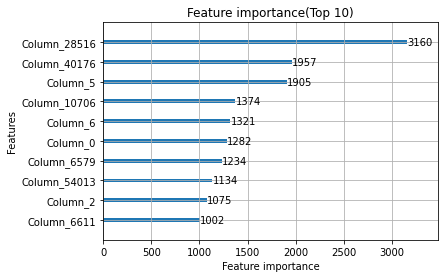

In [0]:
lgb.plot_importance(model, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance(Top 10)', xlabel='Feature importance', 
                    ylabel='Features', importance_type='split',
                    max_num_features=10, ignore_zero=True, figsize=None, 
                    grid=True, precision=3)

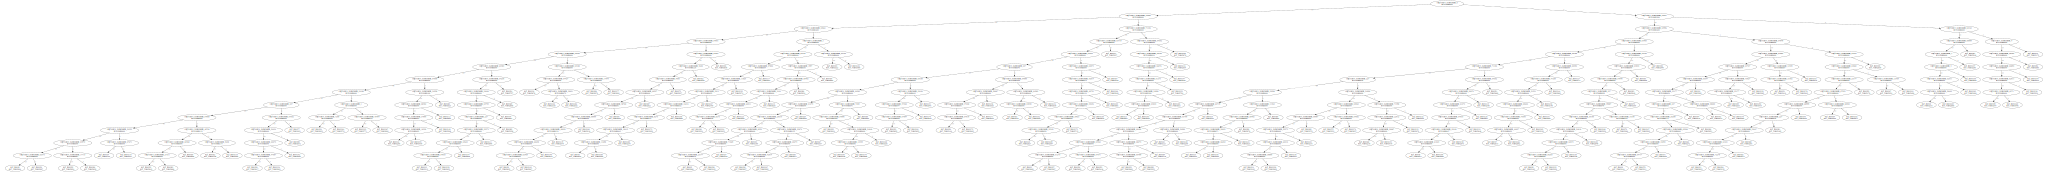

In [0]:
lgb.create_tree_digraph(model, tree_index=0, show_info=None, precision=3, old_name=None, 
                        old_comment=None, old_filename=None, old_directory=None, old_format=None, 
                        old_engine=None, old_encoding=None, old_graph_attr=None, old_node_attr=None, 
                        old_edge_attr=None, old_body=None, old_strict=False, directory='drive/My Drive/mercari/',
                        format='jpg')
                         

In [0]:

lgb_preds_tr = model.predict(X)
lgb_preds_cv = model.predict(X_test)
from sklearn.metrics import mean_squared_error as mse

print('Train RMSLE:', np.sqrt(mse(y, lgb_preds_tr)))

lgb_rmsle = np.sqrt(mse(y_test, lgb_preds_cv))
print("Cross validation RMSLE: ", lgb_rmsle)

Train RMSLE: 0.4100032756638387
Cross validation RMSLE:  0.4530596985787039


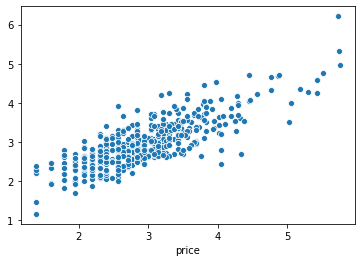

In [0]:
import seaborn as sns
ax = sns.scatterplot(x=y_test[:500], y=lgb_preds_cv[:500])